In [70]:
DATASET_DIR = "C:\\Repos\\Datasets\\multiview_hand_pose_dataset_uploaded_v2"

In [121]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tqdm
import os
import time

In [72]:
# read in first image
# img = plt.imread(DATASET_DIR + "\\annotated_frames\\data_1\\0_webcam_2.jpg")

# # read in the joint locations
# joints = pd.read_csv(DATASET_DIR + "\\projections_2d\\data_1\\0_jointsCam_2.txt", sep=" ", header=None)
# joints.columns = ['Joint', 'X', 'Y']
# joints.head()

In [73]:
from SQLTools import *
import sqlite3

In [74]:
database = Fetch_Database("./Database/joint_data.db")

In [75]:
# create cursor
c = database.cursor()

# get size of database
c.execute("SELECT COUNT(*) FROM data;")
size = c.fetchone()[0]

# pull a random image from the database
image_id = np.random.randint(0, size)

c.execute("SELECT img, label, bbox FROM data WHERE id = ?", (image_id,))
image, label, bbox = c.fetchone()

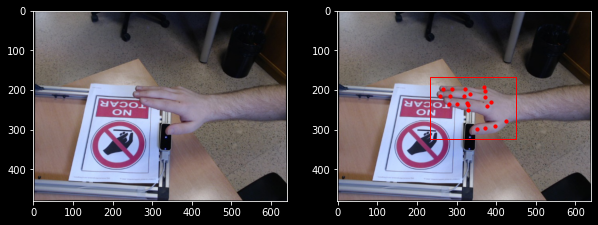

In [80]:
# display the image and its bounding box and joint locations
# bbox is in for [top, left, bottom, right]
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(image)
ax[1].imshow(image)

bbox_rect = patches.Rectangle((bbox[1], bbox[0]), bbox[3] - bbox[1], bbox[2] - bbox[0],  linewidth=1, edgecolor='r', facecolor='none')
ax[1].add_patch(bbox_rect)

# joint labels are between 0 and 1, so we need to scale them to the image size
ax[1].scatter(label[:, 0] * image.shape[1], label[:, 1] * image.shape[0], s=10, c='r')


In [41]:
dataset = Extract_TF_Dataset("./Database/joint_data_lite.db", label_name="bbox")

In [46]:
dataset = dataset.shuffle(buffer_size=1000)
print(dataset.take(1))

<TakeDataset shapes: ((224, 224, 3), (4,)), types: (tf.uint8, tf.float32)>


tf.Tensor([ 54.6      87.5     162.86667 152.95   ], shape=(4,), dtype=float32)


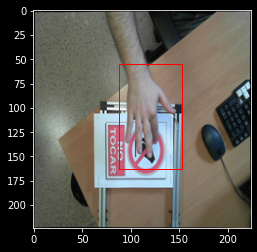

In [89]:
slc = dataset.take(1)
img, bbox = iter(slc).next()
print(bbox)
plt.imshow(img)

# bbox is [top, left, bottom right]
bbox_rect = patches.Rectangle((bbox[1], bbox[0]), bbox[3] - bbox[1],
                              bbox[2] - bbox[0], linewidth=1, edgecolor='r', facecolor='none')
plt.gca().add_patch(bbox_rect)


In [90]:
# Now we want to use a pretrained, lightweight model to transfer learn off of.
# The goal is to find the bounding box from a low-res image, and then use it to crop
# the high-res image.

In [11]:
# # iterate through the rows of the database, pulling out the image and bbox. The image needs to be scaled to 224x224
# # all the images should be added to a tf dataset

# images = np.zeros((size, 224, 224, 3))
# bboxes = np.zeros((size, 4))
# for i in tqdm.tqdm(range(size)):
#     c.execute("SELECT img, bbox FROM data WHERE id = ?", (i+1,))
#     image, bbox = c.fetchone()

#     # save the original image shape
#     original_shape = image.shape

#     # scale the image to 224x224
#     image = tf.image.resize(image, [224, 224])

#     # convert the image to between 0 and 1
#     # image = tf.cast(image, tf.float32) / 255.0

#     # convert the bboxes to between 0 and 1, and rescale them to match the resized image
#     # determine the rescaling factor for both the x and y axis
#     x_scale = 224.0 / original_shape[1]
#     y_scale = 224.0 / original_shape[0]
#     # scale bboxes to 0-1
#     bbox = np.array([bbox[0] / original_shape[0], bbox[1] / original_shape[1], bbox[2] / original_shape[0], bbox[3] / original_shape[1]])
#     # bbox = bbox * [x_scale, y_scale, x_scale, y_scale]

#     # add the image to the dataset
#     images[i] = image
#     # add the bbox to the dataset
#     bboxes[i] = bbox[:,0]


In [91]:
# import mobilenet v2
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [92]:
# create a custom loss function
# the goal is to minimize the difference between the predicted bbox and the actual bbox
# but also to ensure the predicted bbox is not smaller than the actual bbox
def custom_loss(y_true, y_pred, lamda=0.5):
    # mse
    diff = tf.math.abs(y_true - y_pred)
    squ = tf.math.square(diff)
    mse = tf.math.reduce_mean(squ)

    # ensure the predicted bbox is not smaller than the actual bbox
    # calculate the area of the predicted bbox
    pred_area = (y_pred[3] - y_pred[1]) * (y_pred[2] - y_pred[0])
    # calculate the area of the actual bbox
    actual_area = (y_true[3] - y_true[1]) * (y_true[2] - y_true[0])
    # calculate the difference of the predicted bbox to the actual bbox
    # if the predicted bbox is larger, the reation will be negative, rewarding the model
    ratio = actual_area - pred_area
    # pass the ratio through tanh to ensure it is between -1 and 1
    ratio = tf.math.tanh(ratio)

    # calculate the loss
    return lamda * mse + (1 - lamda) * ratio

In [102]:
# setup preprocessing
input_layer = tf.keras.layers.Input(shape=(224, 224, 3))
preprocess_layer = tf.keras.applications.mobilenet_v2.preprocess_input(input_layer)

# load the model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=preprocess_layer)

# freeze the model
base_model.trainable = False

# add a dense layer
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)

# add a dense layer with 4 outputs. They will be the top-left, top-right, bottom-left, bottom-right
# corner of the bounding box.
predictions = tf.keras.layers.Dense(4, activation='linear')(x)

# compile the model
model = tf.keras.models.Model(inputs=input_layer, outputs=predictions)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# print out the model summary
# model.summary()

In [113]:
# create a checkpoint callback
checkpoint_path = "./checkpoints/typeb_5/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_accuracy')

# load the checkpoint if it exists
if os.path.exists(checkpoint_path):
    model.load_weights(checkpoint_path)

In [117]:
# prep the train and validation datasets
dataset = dataset.repeat(2).shuffle(buffer_size=2000)
train_dataset = dataset.take(int(len(dataset) * 0.8)).batch(64)
val_dataset = dataset.skip(int(len(dataset) * 0.8)).batch(64)

In [118]:
# train the model
H = model.fit(train_dataset, validation_data=val_dataset, epochs=10, batch_size=64, callbacks=[cp_callback])

Epoch 1/10
7080/7080 [==============================] - 572s 81ms/step - loss: 11.2744 - accuracy: 0.9321 - val_loss: 6.0819 - val_accuracy: 0.9419
Epoch 2/10
6687/7080 [===========================>..] - ETA: 23s - loss: 5.6110 - accuracy: 0.9454

KeyboardInterrupt: 

Text(0.5, 1.0, 'Training Accuracy')

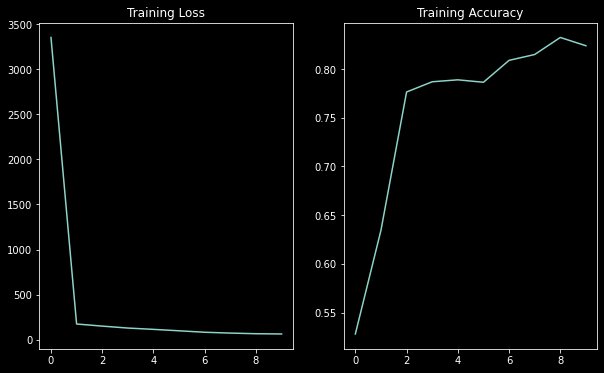

In [119]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
# plot the training history scaled on the left axis
ax[0].plot(H.history['loss'], label='loss')
# plot accuracy on the right axis
ax[1].plot(H.history['accuracy'], label='accuracy')
ax[0].set_title('Training Loss')
ax[1].set_title('Training Accuracy')

Prediction took 0.0464935302734375 seconds


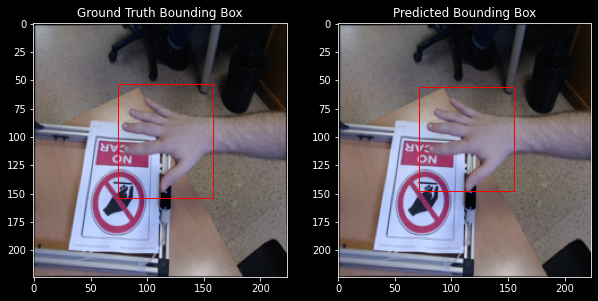

In [125]:
# display some predictions
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

# fetch a random image from the validation dataset
image, ground_truth = next(iter(dataset))

# time the prediction
start = time.time()

# predict the bounding box
bbox = model.predict(image[np.newaxis, :, :, :])[0]

print("Prediction took {} seconds".format(time.time() - start))

# display the image and the ground truth bounding box
ax[0].imshow(image)
gt_bbox_rect = patches.Rectangle(
    (ground_truth[1], ground_truth[0]), ground_truth[3] - ground_truth[1], ground_truth[2] - ground_truth[0], linewidth=1, edgecolor='r', facecolor='none')
ax[0].add_patch(gt_bbox_rect)
ax[0].set_title('Ground Truth Bounding Box')

# display the image and the predicted bounding box
ax[1].imshow(image)
bbox_rect = patches.Rectangle((bbox[1], bbox[0]), bbox[3] - bbox[1],
                              bbox[2] - bbox[0], linewidth=1, edgecolor='r', facecolor='none')
ax[1].add_patch(bbox_rect)
ax[1].set_title('Predicted Bounding Box')

plt.show()


In [126]:
# save the model to an h5 file
model.save('typeb_5.h5')

C:\Users\jtalo\.conda\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
